## Lineare und polynomiale Regression zur Preisgestaltung von Kürbissen - Lektion 3

Laden Sie die erforderlichen Bibliotheken und den Datensatz. Konvertieren Sie die Daten in ein DataFrame, das einen Teil der Daten enthält:

- Nur Kürbisse berücksichtigen, die pro Scheffel bepreist sind
- Das Datum in einen Monat umwandeln
- Den Preis als Durchschnitt aus Höchst- und Tiefstpreisen berechnen
- Den Preis so umrechnen, dass er die Preisgestaltung pro Scheffelmenge widerspiegelt


In [167]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

pumpkins = pd.read_csv('../../data/US-pumpkins.csv')
pumpkins.head()

City Name Type       Package      Variety Sub Variety  Grade     Date  \
0  BALTIMORE  NaN  24 inch bins          NaN         NaN    NaN  4/29/17   
1  BALTIMORE  NaN  24 inch bins          NaN         NaN    NaN   5/6/17   
2  BALTIMORE  NaN  24 inch bins  HOWDEN TYPE         NaN    NaN  9/24/16   
3  BALTIMORE  NaN  24 inch bins  HOWDEN TYPE         NaN    NaN  9/24/16   
4  BALTIMORE  NaN  24 inch bins  HOWDEN TYPE         NaN    NaN  11/5/16   

   Low Price  High Price  Mostly Low  ...  Unit of Sale Quality Condition  \
0      270.0       280.0       270.0  ...           NaN     NaN       NaN   
1      270.0       280.0       270.0  ...           NaN     NaN       NaN   
2      160.0       160.0       160.0  ...           NaN     NaN       NaN   
3      160.0       160.0       160.0  ...           NaN     NaN       NaN   
4       90.0       100.0        90.0  ...           NaN     NaN       NaN   

  Appearance Storage  Crop Repack  Trans Mode  Unnamed: 24  Unnamed: 25  
0        NaN     NaN   NaN      E         NaN          NaN          NaN  
1        NaN     NaN   NaN      E         NaN          NaN          NaN  
2        NaN     NaN   NaN      N         NaN          NaN          NaN  
3        NaN     NaN   NaN      N         NaN          NaN          NaN  
4        NaN     NaN   NaN      N         NaN          NaN          NaN  

[5 rows x 26 columns]

In [168]:
pumpkins = pumpkins[pumpkins['Package'].str.contains('bushel', case=True, regex=True)]

new_columns = ['Package', 'Variety', 'City Name', 'Month', 'Low Price', 'High Price', 'Date']
pumpkins = pumpkins.drop([c for c in pumpkins.columns if c not in new_columns], axis=1)

price = (pumpkins['Low Price'] + pumpkins['High Price']) / 2

month = pd.DatetimeIndex(pumpkins['Date']).month
day_of_year = pd.to_datetime(pumpkins['Date']).apply(lambda dt: (dt-datetime(dt.year,1,1)).days)

new_pumpkins = pd.DataFrame(
    {'Month': month, 
     'DayOfYear' : day_of_year, 
     'Variety': pumpkins['Variety'], 
     'City': pumpkins['City Name'], 
     'Package': pumpkins['Package'], 
     'Low Price': pumpkins['Low Price'],
     'High Price': pumpkins['High Price'], 
     'Price': price})

new_pumpkins.loc[new_pumpkins['Package'].str.contains('1 1/9'), 'Price'] = price/1.1
new_pumpkins.loc[new_pumpkins['Package'].str.contains('1/2'), 'Price'] = price*2

new_pumpkins.head()


Month  DayOfYear   Variety       City               Package  Low Price  \
70      9        267  PIE TYPE  BALTIMORE  1 1/9 bushel cartons       15.0   
71      9        267  PIE TYPE  BALTIMORE  1 1/9 bushel cartons       18.0   
72     10        274  PIE TYPE  BALTIMORE  1 1/9 bushel cartons       18.0   
73     10        274  PIE TYPE  BALTIMORE  1 1/9 bushel cartons       17.0   
74     10        281  PIE TYPE  BALTIMORE  1 1/9 bushel cartons       15.0   

    High Price      Price  
70        15.0  13.636364  
71        18.0  16.363636  
72        18.0  16.363636  
73        17.0  15.454545  
74        15.0  13.636364

Ein Streudiagramm erinnert uns daran, dass wir nur Monatsdaten von August bis Dezember haben. Wir benötigen wahrscheinlich mehr Daten, um Schlussfolgerungen auf lineare Weise ziehen zu können.


<AxesSubplot:xlabel='Month', ylabel='Price'>

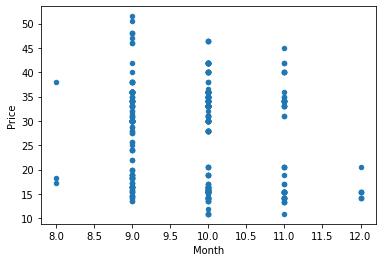

In [169]:
new_pumpkins.plot.scatter('Month','Price')

<AxesSubplot:xlabel='DayOfYear', ylabel='Price'>

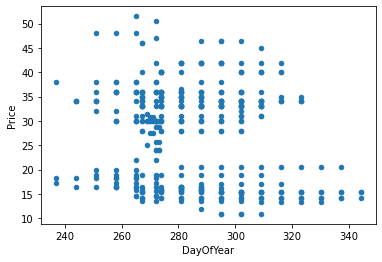

In [170]:
new_pumpkins.plot.scatter('DayOfYear','Price')

In [171]:
print(new_pumpkins['Month'].corr(new_pumpkins['Price']))
print(new_pumpkins['DayOfYear'].corr(new_pumpkins['Price']))

-0.14878293554077535
-0.16673322492745407


Es sieht so aus, als ob die Korrelation ziemlich gering ist, aber es gibt eine andere, wichtigere Beziehung – denn die Preispunkte im obigen Diagramm scheinen mehrere unterschiedliche Cluster zu haben. Lassen Sie uns ein Diagramm erstellen, das verschiedene Kürbissorten zeigt:


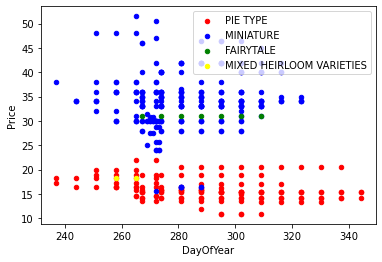

In [172]:
ax=None
colors = ['red','blue','green','yellow']
for i,var in enumerate(new_pumpkins['Variety'].unique()):
    ax = new_pumpkins[new_pumpkins['Variety']==var].plot.scatter('DayOfYear','Price',ax=ax,c=colors[i],label=var)

<AxesSubplot:xlabel='Variety'>

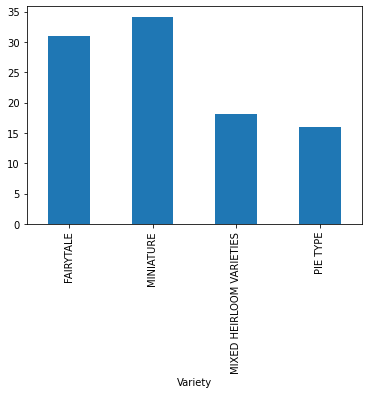

In [173]:
new_pumpkins.groupby('Variety')['Price'].mean().plot(kind='bar')

-0.2669192282197318


<AxesSubplot:xlabel='DayOfYear', ylabel='Price'>

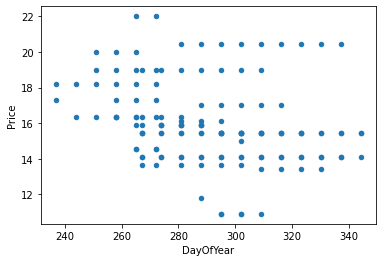

In [174]:
pie_pumpkins = new_pumpkins[new_pumpkins['Variety']=='PIE TYPE']
print(pie_pumpkins['DayOfYear'].corr(pie_pumpkins['Price']))
pie_pumpkins.plot.scatter('DayOfYear','Price')

### Lineare Regression

Wir werden Scikit Learn verwenden, um ein lineares Regressionsmodell zu trainieren:


In [175]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

In [176]:
X = pie_pumpkins['DayOfYear'].to_numpy().reshape(-1,1)
y = pie_pumpkins['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
lin_reg = LinearRegression()
lin_reg.fit(X_train,y_train)

pred = lin_reg.predict(X_test)

mse = np.sqrt(mean_squared_error(y_test,pred))
print(f'Mean error: {mse:3.3} ({mse/np.mean(pred)*100:3.3}%)')


Mean error: 2.77 (17.2%)


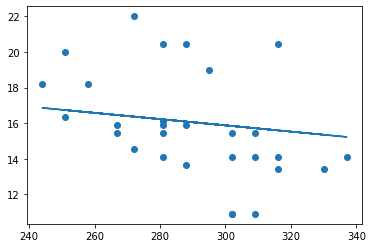

In [177]:
plt.scatter(X_test,y_test)
plt.plot(X_test,pred)

Die Steigung der Linie kann aus den Koeffizienten der linearen Regression bestimmt werden:


In [178]:
lin_reg.coef_, lin_reg.intercept_

(array([-0.01751876]), 21.133734359909326)

Wir können das trainierte Modell verwenden, um den Preis vorherzusagen:


In [179]:
# Pumpkin price on programmer's day

lin_reg.predict([[256]])

array([16.64893156])

### Polynomiale Regression

Manchmal ist die Beziehung zwischen Merkmalen und Ergebnissen von Natur aus nicht linear. Zum Beispiel könnten Kürbispreise im Winter (Monate=1,2) hoch sein, dann im Sommer (Monate=5-7) sinken und anschließend wieder steigen. Lineare Regression kann diese Beziehung nicht genau erfassen.

In diesem Fall könnten wir in Betracht ziehen, zusätzliche Merkmale hinzuzufügen. Eine einfache Methode ist die Verwendung von Polynomen aus Eingabemerkmalen, was zu einer **polynomialen Regression** führt. In Scikit Learn können wir polynomiale Merkmale automatisch mithilfe von Pipelines vorab berechnen:


Mean error: 2.73 (17.0%)
Model determination:  0.07639977655280217


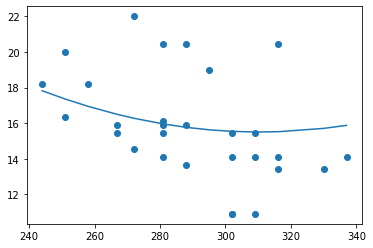

In [180]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(PolynomialFeatures(2), LinearRegression())

pipeline.fit(X_train,y_train)

pred = pipeline.predict(X_test)

mse = np.sqrt(mean_squared_error(y_test,pred))
print(f'Mean error: {mse:3.3} ({mse/np.mean(pred)*100:3.3}%)')

score = pipeline.score(X_train,y_train)
print('Model determination: ', score)

plt.scatter(X_test,y_test)
plt.plot(sorted(X_test),pipeline.predict(sorted(X_test)))

### Kodierung von Sorten

In einer idealen Welt möchten wir in der Lage sein, die Preise für verschiedene Kürbissorten mit demselben Modell vorherzusagen. Um die Sorte zu berücksichtigen, müssen wir sie zunächst in numerische Form umwandeln, oder **kodieren**. Es gibt mehrere Möglichkeiten, dies zu tun:

* Eine einfache numerische Kodierung, die eine Tabelle mit verschiedenen Sorten erstellt und dann den Sortennamen durch einen Index in dieser Tabelle ersetzt. Dies ist keine gute Idee für die lineare Regression, da die lineare Regression den numerischen Wert des Index berücksichtigt und dieser numerische Wert wahrscheinlich nicht numerisch mit dem Preis korreliert.
* One-Hot-Encoding, das die `Variety`-Spalte durch 4 verschiedene Spalten ersetzt, eine für jede Sorte, die 1 enthält, wenn die entsprechende Zeile zur angegebenen Sorte gehört, und 0, wenn nicht.

Der folgende Code zeigt, wie wir eine Sorte mit One-Hot-Encoding kodieren können:


In [181]:
pd.get_dummies(new_pumpkins['Variety'])

FAIRYTALE  MINIATURE  MIXED HEIRLOOM VARIETIES  PIE TYPE
70            0          0                         0         1
71            0          0                         0         1
72            0          0                         0         1
73            0          0                         0         1
74            0          0                         0         1
...         ...        ...                       ...       ...
1738          0          1                         0         0
1739          0          1                         0         0
1740          0          1                         0         0
1741          0          1                         0         0
1742          0          1                         0         0

[415 rows x 4 columns]

### Lineare Regression auf Sorten

Wir verwenden nun denselben Code wie oben, aber anstelle von `DayOfYear` nutzen wir unsere one-hot-codierte Sorte als Eingabe:


In [182]:
X = pd.get_dummies(new_pumpkins['Variety'])
y = new_pumpkins['Price']

In [183]:
def run_linear_regression(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    lin_reg = LinearRegression()
    lin_reg.fit(X_train,y_train)

    pred = lin_reg.predict(X_test)

    mse = np.sqrt(mean_squared_error(y_test,pred))
    print(f'Mean error: {mse:3.3} ({mse/np.mean(pred)*100:3.3}%)')

    score = lin_reg.score(X_train,y_train)
    print('Model determination: ', score)

run_linear_regression(X,y)

Mean error: 5.24 (19.7%)
Model determination:  0.774085281105197


Wir können auch versuchen, andere Funktionen auf die gleiche Weise zu verwenden und sie mit numerischen Merkmalen wie `Month` oder `DayOfYear` zu kombinieren:


In [184]:
X = pd.get_dummies(new_pumpkins['Variety']) \
        .join(new_pumpkins['Month']) \
        .join(pd.get_dummies(new_pumpkins['City'])) \
        .join(pd.get_dummies(new_pumpkins['Package']))
y = new_pumpkins['Price']

run_linear_regression(X,y)

Mean error: 2.84 (10.5%)
Model determination:  0.9401096672643048


### Polynomiale Regression

Polynomiale Regression kann auch mit kategorialen Merkmalen verwendet werden, die als One-Hot-Encoding dargestellt sind. Der Code zum Trainieren der polynomialen Regression wäre im Wesentlichen derselbe wie oben gezeigt.


In [185]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(PolynomialFeatures(2), LinearRegression())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

pipeline.fit(X_train,y_train)

pred = pipeline.predict(X_test)

mse = np.sqrt(mean_squared_error(y_test,pred))
print(f'Mean error: {mse:3.3} ({mse/np.mean(pred)*100:3.3}%)')

score = pipeline.score(X_train,y_train)
print('Model determination: ', score)

Mean error: 2.23 (8.25%)
Model determination:  0.9652870784724543



---

**Haftungsausschluss**:  
Dieses Dokument wurde mithilfe des KI-Übersetzungsdienstes [Co-op Translator](https://github.com/Azure/co-op-translator) übersetzt. Obwohl wir uns um Genauigkeit bemühen, weisen wir darauf hin, dass automatisierte Übersetzungen Fehler oder Ungenauigkeiten enthalten können. Das Originaldokument in seiner ursprünglichen Sprache sollte als maßgebliche Quelle betrachtet werden. Für kritische Informationen wird eine professionelle menschliche Übersetzung empfohlen. Wir übernehmen keine Haftung für Missverständnisse oder Fehlinterpretationen, die sich aus der Nutzung dieser Übersetzung ergeben.
